In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/surface-crack/valid/Negative/IMG_2626_8_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0293_4_10.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2979_8_7.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2511_4_13.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_9627_8_9.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0254_7_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2977_3_3.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0254_9_6.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2016_1_11.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2010_2_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_1424_5_16.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2979_8_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0472_10_10.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0471_3_5.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2015_11_3.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2626_8_7.jpg
/kaggle/input/surface-crack/valid

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision
import numpy as np
import os
cwd = os.getcwd()
from PIL import Image
import time
import copy
import random
import cv2
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
crack_images = os.listdir('/kaggle/input/surface-crack/train/Positive')
print("Number of Crack Images: ", len(crack_images))

Number of Crack Images:  300


In [4]:


no_crack_images = os.listdir('/kaggle/input/surface-crack/train/Negative')
print("Number of No Crack Images: ", len(no_crack_images))

Number of No Crack Images:  300


*****************Random Images with Cracks**************************


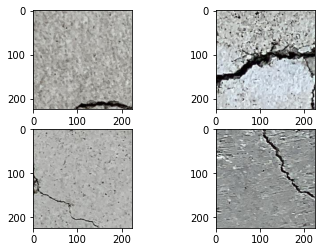

In [5]:
## Visualize Random images with cracks
random_indices = np.random.randint(0, len(crack_images), size=4)
print("*****************Random Images with Cracks**************************")
random_images = np.array(crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, '/kaggle/input/surface-crack/train/Positive', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, '/kaggle/input/surface-crack/train/Positive', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, '/kaggle/input/surface-crack/train/Positive', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, '/kaggle/input/surface-crack/train/Positive', random_images[3])))

*****************Random Images without Cracks**************************


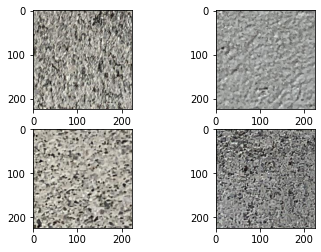

In [6]:


## Visualize Random images with no cracks
random_indices = np.random.randint(0, len(no_crack_images), size=4)
print("*****************Random Images without Cracks**************************")
random_images = np.array(no_crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, '/kaggle/input/surface-crack/train/Negative', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, '/kaggle/input/surface-crack/train/Negative', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, '/kaggle/input/surface-crack/train/Negative', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, '/kaggle/input/surface-crack/train/Negative', random_images[3])))



In [7]:
base_dir = cwd
files = os.listdir(base_dir)

def create_training_data(folder_name):
    train_dir = f"{base_dir}/train/{folder_name}"
    for f in files:
        search_object = re.search(folder_name, f)
        if search_object:
            shutil.move(f'{base_dir}/{folder_name}', train_dir)

In [8]:
create_training_data('/kaggle/input/surface-crack/train/Positive')
create_training_data('/kaggle/input/surface-crack/train/Negative')

In [9]:
create_training_data

<function __main__.create_training_data(folder_name)>

In [10]:
os.makedirs('val/Positive')
os.makedirs('val/Negative')

In [11]:
positive_train ="/kaggle/input/surface-crack/train/Positive"
positive_val = "/kaggle/input/surface-crack/valid/Positive"
negative_train ="/kaggle/input/surface-crack/train/Negative"
negative_val = "/kaggle/input/surface-crack/valid/Negative"

positive_files = os.listdir(positive_train)
negative_files = os.listdir(negative_train)

In [12]:
print(len(positive_files), len(negative_files))

300 300


In [13]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]



In [14]:
## Define data augmentation and transforms
chosen_transforms = {'/kaggle/input/surface-crack/train': transforms.Compose([
        transforms.RandomResizedCrop(size=227),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), '/kaggle/input/surface-crack/valid': transforms.Compose([
        transforms.Resize(227),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), '/kaggle/input/surface-crack/predict': transforms.Compose([
        transforms.Resize(227),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
])
}

In [15]:


## Create the data loader
def load_dataset(format, batch_size):
    data_path = os.path.join(cwd, format)
    dataset = datasets.ImageFolder(
        root=data_path,
        transform= chosen_transforms[format]
    )
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        shuffle=True
    )
    return data_loader, len(dataset), dataset.classes



In [16]:


## Set code to run on device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



cuda


In [17]:
train_loader, train_size, class_names = load_dataset('/kaggle/input/surface-crack/train', 8)
print("Train Data Set size is: ", train_size)
print("Class Names are: ", class_names)
inputs, classes = next(iter(train_loader))
print(inputs.shape, classes.shape)

Train Data Set size is:  600
Class Names are:  ['Negative', 'Positive']
torch.Size([8, 3, 227, 227]) torch.Size([8])


In [18]:


# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

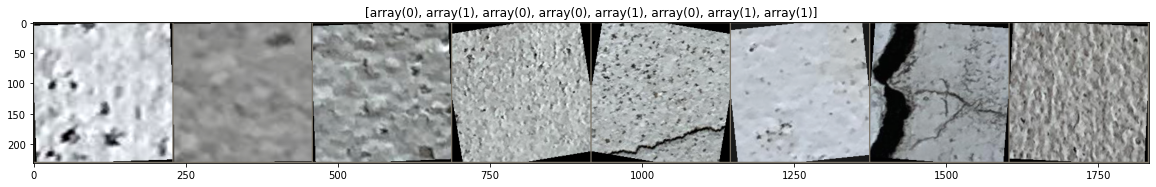

In [19]:
# Grab some of the training data to visualize
inputs, classes = next(iter(train_loader))
# class_names = chosen_datasets['train'].classes
# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

idx_to_class = {0:'Negative', 1:'Positive'}
plt.figure(figsize=(20,10))
imshow(out, title=[x.data.numpy() for x in classes])

In [20]:
!pip install torch-summary

In [21]:
## Load pretrained model
resnet50 = models.resnet50(pretrained=True)
# Freeze model parameters
for name, child in resnet50.named_children():
    if name in ['layer3', 'layer4']:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in child.parameters():
            param.requires_grad = False
# for param in resnet50.parameters():
#     param.requires_grad = False

## Change the final layer of the resnet model
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
 
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128,2),
    nn.Sigmoid()
)

# Convert model to be used on GPU
resnet50 = resnet50.to(device)

from torchsummary import summary
print(summary(resnet50, (3, 227, 227)))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is frozen
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 114, 114]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 114, 114]        (128)
├─ReLU: 1-3                              [-1, 64, 114, 114]        --
├─MaxPool2d: 1-4                         [-1, 64, 57, 57]          --
├─Sequential: 1-5                        [-1, 256, 57, 57]         --
|    └─Bottleneck: 2-1                   [-1, 256, 57, 57]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 57, 57]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 57, 57]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 57, 57]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 57, 57]          (36,864)
|    |    └─BatchNorm2d: 3-5         

In [22]:
## Load pretrained model
inception = models.inception_v3(pretrained=True)
# Freeze model parameters
for name, child in inception.named_children():
    if name in ['Mixed_7a', 'Mixed_7b', 'Mixed_7c']:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in child.parameters():
            param.requires_grad = False
# for param in resnet50.parameters():
#     param.requires_grad = False

## Change the final layer of the resnet model
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = inception.fc.in_features
 
inception.fc = nn.Sequential(
    nn.Linear(fc_inputs, 192),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(192,2),
    nn.Sigmoid()
)
# Convert model to be used on GPU
inception = inception.to(device)

from torchsummary import summary
print(summary(inception, (3, 227, 227)))

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Conv2d_1a_3x3 is frozen
Conv2d_2a_3x3 is frozen
Conv2d_2b_3x3 is frozen
maxpool1 is frozen
Conv2d_3b_1x1 is frozen
Conv2d_4a_3x3 is frozen
maxpool2 is frozen
Mixed_5b is frozen
Mixed_5c is frozen
Mixed_5d is frozen
Mixed_6a is frozen
Mixed_6b is frozen
Mixed_6c is frozen
Mixed_6d is frozen
Mixed_6e is frozen
AuxLogits is frozen
Mixed_7a is unfrozen
Mixed_7b is unfrozen
Mixed_7c is unfrozen
avgpool is frozen
dropout is frozen
fc is frozen
Layer (type:depth-idx)                   Output Shape              Param #
├─BasicConv2d: 1-1                       [-1, 32, 113, 113]        --
|    └─Conv2d: 2-1                       [-1, 32, 113, 113]        (864)
|    └─BatchNorm2d: 2-2                  [-1, 32, 113, 113]        (64)
├─BasicConv2d: 1-2                       [-1, 32, 111, 111]        --
|    └─Conv2d: 2-3                       [-1, 32, 111, 111]        (9,216)
|    └─BatchNorm2d: 2-4                  [-1, 32, 111, 111]        (64)
├─BasicConv2d: 1-3                       [-1, 64, 1

In [23]:
## Load pretrained model
vgg16_bn = models.vgg16_bn(pretrained=True)
# Freeze model parameters
for name, child in vgg16_bn.named_children():
    if name in ['classifier']:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in child.parameters():
            param.requires_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16_bn.classifier[6].in_features
features = list(vgg16_bn.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names)), nn.Sigmoid()]) # Add our layer with 4 outputs
vgg16_bn.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16_bn)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

features is frozen
avgpool is frozen
classifier is unfrozen
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, paddi

In [24]:


# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters())
# optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [25]:

# Define Optimizer and Loss Function
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(resnet50.parameters())
# optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler2 = lr_scheduler.StepLR(optimizer2, step_size=3, gamma=0.1)

In [26]:

# Define Optimizer and Loss Function
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(vgg16_bn.parameters())
# optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler3 = lr_scheduler.StepLR(optimizer3, step_size=3, gamma=0.1)

In [27]:
dataloaders = {}
dataset_sizes = {}
batch_size = 256
dataloaders['/kaggle/input/surface-crack/train'], dataset_sizes['/kaggle/input/surface-crack/train'], class_names = load_dataset('/kaggle/input/surface-crack/train', batch_size)
dataloaders['/kaggle/input/surface-crack/valid'], dataset_sizes['/kaggle/input/surface-crack/valid'], _ = load_dataset('/kaggle/input/surface-crack/valid', batch_size)
idx_to_class = {0:'Negative', 1:'Positive'}

## Single Model Test(Resnet)

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1=0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['/kaggle/input/surface-crack/train', '/kaggle/input/surface-crack/valid']:
            if phase == '/kaggle/input/surface-crack/train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == '/kaggle/input/surface-crack/train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == '/kaggle/input/surface-crack/train':
                        loss.backward()
                        optimizer.step()
           

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                true_positive=0
                false_negative=0
                false_positive=0
                for i in range(len(labels.data)):
                    
                    if labels.data[i]==1:
                        if preds[i]== labels.data[i]:
                            true_positive+=1
                        else:
                            false_negative+=1
                    else:
                        if preds[i]!= labels.data[i]:
                            false_positive+=1 
                    
            epoch_precision=(true_positive)/(true_positive+false_positive)
            epoch_recall=(true_positive)/(true_positive+false_negative)
            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]
            epoch_f1=2*epoch_precision*epoch_recall/(epoch_recall+epoch_precision)
            print('{} Loss: {:.4f} Acc: {:.4f} precision: {:.4f} recall: {:.4f} f1score: {:.4f}'.format(
                phase, epoch_loss, epoch_acc,epoch_precision,epoch_recall,epoch_f1))
            
            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == '/kaggle/input/surface-crack/valid' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_precision=epoch_precision
                best_recall=epoch_recall
                best_model_wts = copy.deepcopy(model.state_dict())


    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val F1 score is: {:4f}'.format(best_f1))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [30]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['/kaggle/input/surface-crack/valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 0/5
----------
Iterating through data...
/kaggle/input/surface-crack/train Loss: 0.4298 Acc: 0.8817 precision: 0.8919 recall: 0.8684 f1score: 0.8800
Iterating through data...
/kaggle/input/surface-crack/valid Loss: 0.3880 Acc: 0.9300 precision: 0.8772 recall: 1.0000 f1score: 0.9346
Epoch 1/5
----------
Iterating through data...
/kaggle/input/surface-crack/train Loss: 0.4347 Acc: 0.8817 precision: 0.8824 recall: 0.7895 f1score: 0.8333
Iterating through data...
/kaggle/input/surface-crack/valid Loss: 0.3883 Acc: 0.9300 precision: 0.8772 recall: 1.0000 f1score: 0.9346
Epoch 2/5
----------
Iterating through data...
/kaggle/input/surface-crack/train Loss: 0.4266 Acc: 0.8850 precision: 0.8750 recall: 0.8974 f1score: 0.8861
Iterating through data...
/kaggle/input/surface-crack/valid Loss: 0.3868 Acc: 0.9300 precision: 0.8772 recall: 1.0000 f1score: 0.9346
Epoch 3/5
----------
Iterating through data...
/kaggle/input/surface-crack/train Loss: 0.4297 Acc: 0.8783 precision: 0.8750 recall: 0

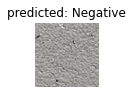

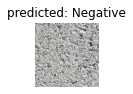

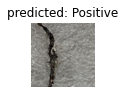

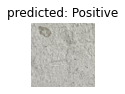

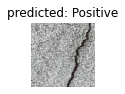

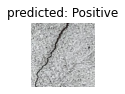

In [31]:
base_model = train_model(resnet50,criterion, optimizer, exp_lr_scheduler, num_epochs=6)
visualize_model(base_model)
plt.show()

## Ensemble of VGG16_BN,Resnet50 and InceptionV3

In [32]:
def train_model(model,model2,model3, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_model_wts2 = copy.deepcopy(model2.state_dict())
    best_model_wts3 = copy.deepcopy(model3.state_dict())
    best_acc = 0.0
    best_f1=0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['/kaggle/input/surface-crack/train', '/kaggle/input/surface-crack/valid']:
            if phase == '/kaggle/input/surface-crack/train':
                scheduler.step()
                model.train()
                model2.train()
                model3.train()
                # Set model to training mode
            else:
                model.eval()
                model2.eval()
                model3.eval()# Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()
                optimizer2.zero_grad()
                optimizer3.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == '/kaggle/input/surface-crack/train'):
                    outputs = model(inputs)
                    outputs2 = model2(inputs)
                    outputs3 = model3(inputs)
                    _, preds = torch.max((outputs+outputs2+outputs3)/3, 1)
                    print((_))
                    print(preds)
                    
                    loss = criterion(outputs, labels)
                    loss2 = criterion2(outputs2, labels)
                    loss3 = criterion3(outputs3, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == '/kaggle/input/surface-crack/train':
                        loss.backward()
                        optimizer.step()
                        loss2.backward()
                        optimizer2.step()
                        loss3.backward()
                        optimizer3.step()

                    

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                true_positive=0
                false_negative=0
                false_positive=0
                for i in range(len(labels.data)):
                    
                    if labels.data[i]==1:
                        if preds[i]== labels.data[i]:
                            true_positive+=1
                        else:
                            false_negative+=1
                    else:
                        if preds[i]!= labels.data[i]:
                            false_positive+=1 
                    
            epoch_precision=(true_positive)/(true_positive+false_positive)
            epoch_recall=(true_positive)/(true_positive+false_negative)
            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]
            epoch_f1=2*epoch_precision*epoch_recall/(epoch_recall+epoch_precision)
            print('{} Loss: {:.4f} Acc: {:.4f} precision: {:.4f} recall: {:.4f} f1score: {:.4f}'.format(
                phase, epoch_loss, epoch_acc,epoch_precision,epoch_recall,epoch_f1))
            
            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == '/kaggle/input/surface-crack/valid' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_precision=epoch_precision
                best_recall=epoch_recall
                best_model_wts = copy.deepcopy(model.state_dict())
                best_model_wts2 = copy.deepcopy(model2.state_dict())
                best_model_wts3 = copy.deepcopy(model3.state_dict())
                


    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val F1 score is: {:4f}'.format(best_f1))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [104]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['/kaggle/input/surface-crack/valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 0/5
----------
Iterating through data...


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


/kaggle/input/surface-crack/train Loss: 0.6537 Acc: 0.6167 precision: 0.6765 recall: 0.9787 f1score: 0.8000
Iterating through data...
/kaggle/input/surface-crack/valid Loss: 1.8530 Acc: 0.7400 precision: 0.6579 recall: 1.0000 f1score: 0.7937
Epoch 1/5
----------
Iterating through data...
/kaggle/input/surface-crack/train Loss: 0.3792 Acc: 0.8317 precision: 0.9667 recall: 0.6170 f1score: 0.7532
Iterating through data...
/kaggle/input/surface-crack/valid Loss: 2.2970 Acc: 0.5100 precision: 0.5051 recall: 1.0000 f1score: 0.6711
Epoch 2/5
----------
Iterating through data...
/kaggle/input/surface-crack/train Loss: 0.3654 Acc: 0.8050 precision: 0.7609 recall: 0.8333 f1score: 0.7955
Iterating through data...
/kaggle/input/surface-crack/valid Loss: 0.9214 Acc: 0.5500 precision: 0.5263 recall: 1.0000 f1score: 0.6897
Epoch 3/5
----------
Iterating through data...
/kaggle/input/surface-crack/train Loss: 0.2970 Acc: 0.8583 precision: 0.9302 recall: 0.8696 f1score: 0.8989
Iterating through data...

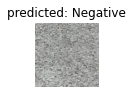

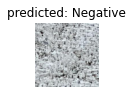

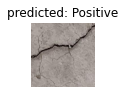

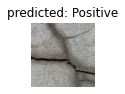

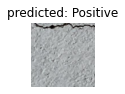

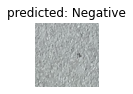

In [26]:
base_model = train_model(resnet50,inception,vgg16_bn, criterion, optimizer, exp_lr_scheduler, num_epochs=6)
visualize_model(base_model)
plt.show()

In [105]:
def predict(model, test_image, print_class = False):
     
    transform = chosen_transforms['/kaggle/input/surface-crack/predict']
     
    test_image_tensor = transform(test_image)
 
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227)
     
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        class_name = idx_to_class[topclass.cpu().numpy()[0][0]]
        if print_class:
            print("Output class :  ", class_name)
    return class_name

In [106]:

def predict_on_crops(input_image, height=227, width=227, save_crops = False):
    im = cv2.imread(input_image)
    imgheight, imgwidth, channels = im.shape
    k=0
    output_image = np.zeros_like(im)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            ## discard image cropss that are not full size
            predicted_class = predict(base_model,Image.fromarray(a))
            ## save image
            file, ext = os.path.splitext(input_image)
            image_name = file.split('/')[-1]
            folder_name = 'out_' + image_name
            ## Put predicted class on the image
            if predicted_class == 'Positive':
                color = (0,0, 255)
            else:
                color = (0, 255, 0)
            cv2.putText(a, predicted_class, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 0.7, color, 1, cv2.LINE_AA) 
            b = np.zeros_like(a, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0)
            ## Save crops
            if save_crops:
                if not os.path.exists(os.path.join('real_images', folder_name)):
                    os.makedirs(os.path.join('real_images', folder_name))
                filename = os.path.join('real_images', folder_name,'img_{}.png'.format(k))
                cv2.imwrite(filename, add_img)
            output_image[i:i+height, j:j+width,:] = add_img
            k+=1
    ## Save output image
    cv2.imwrite(os.path.join('real_images','predictions', folder_name+ '.jpg'), output_image)
    return output_image



## Prediction On Predict Files(red area denotes crack detected and green is no cracks)

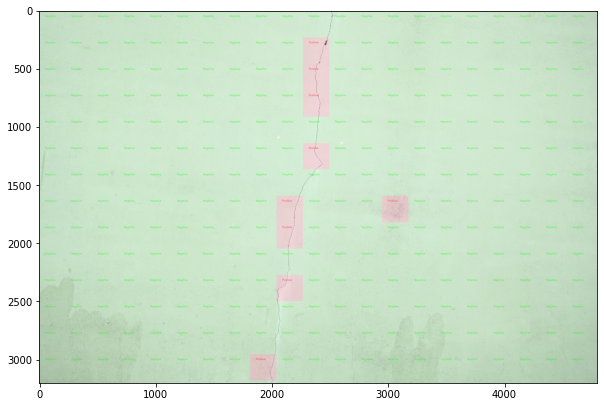

In [38]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('/kaggle/input/surface-crack/predict/IMG_1129.JPG', 227, 227)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))



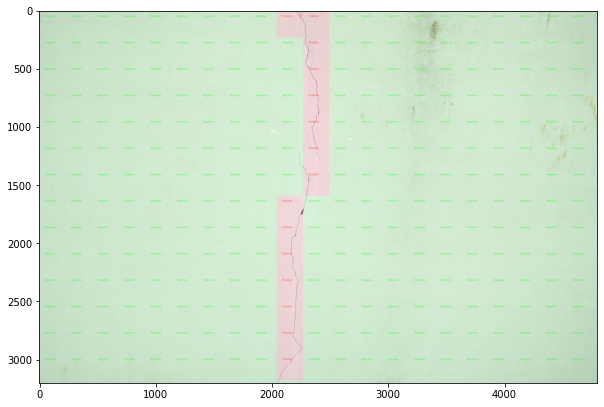

In [39]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('/kaggle/input/surface-crack/predict/IMG_1130.JPG', 227, 227)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))


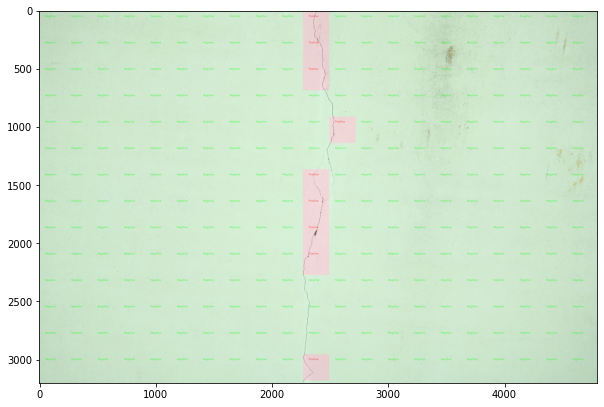

In [40]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('/kaggle/input/surface-crack/predict/IMG_1131.JPG', 227, 227)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))


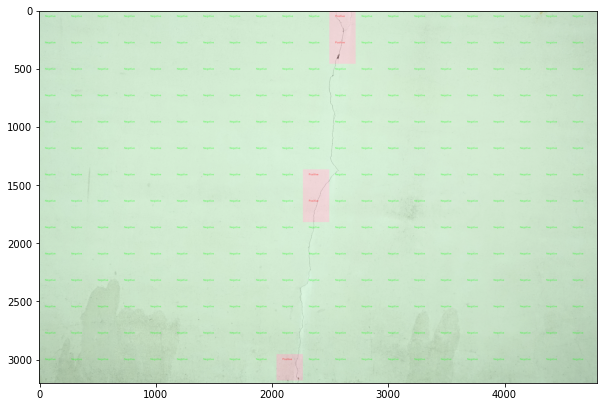

In [41]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('/kaggle/input/surface-crack/predict/IMG_1132.JPG', 227, 227)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))


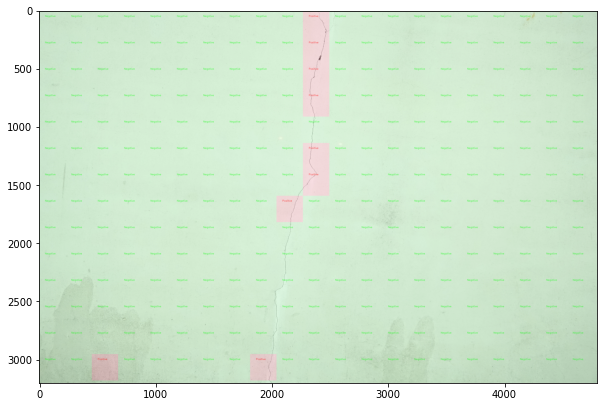

In [42]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('/kaggle/input/surface-crack/predict/IMG_1133.JPG', 227, 227)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

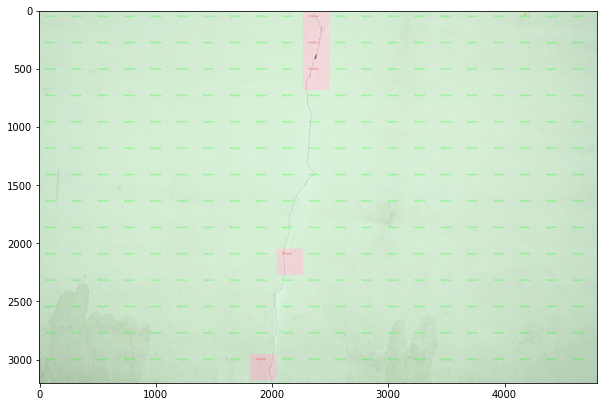

In [43]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('/kaggle/input/surface-crack/predict/IMG_1134.JPG', 227, 227)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))